# Estimating COVID-19's $R_t$ in Real-Time
Kevin Systrom - April 17

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, we don't yet use $R_t$ in this way. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While this paper estimates a static $R$ value, here we introduce a process model with Gaussian noise to estimate a time-varying $R_t$.

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so you can calibrate your beliefs as you wish. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.

Additionally, a huge thanks to [Frank Dellaert](http://www.twitter.com/fdellaert/) who suggested the addition of the process and to [Adam Lerer](http://www.twitter.com/adamlerer/) who implemented the changes. Not only did I learn something new, it made the model much more responsive.

In [38]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output


%config InlineBackend.figure_format = 'retina'

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __likelihood__ of seeing $k$ new cases given $R_t$ times ...
- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

etc.

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [39]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __Note__: this was a terse expression which makes it tricky. All I did was to make $k$ a column. By giving it a column for $k$ and a 'row' for lambda it will evaluate the pmf over both and produce an array that has $k$ rows and lambda columns. This is an efficient way of producing many distributions all at once, and __you will see it used again below__!

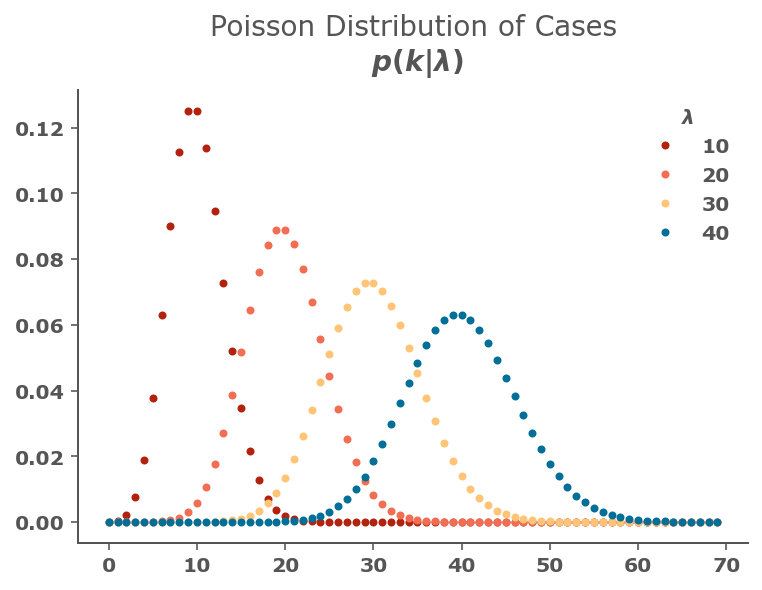

In [40]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

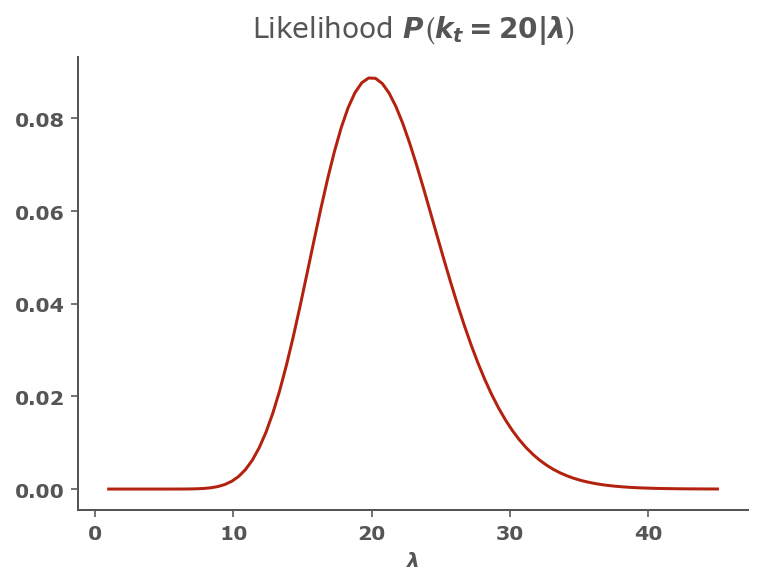

In [41]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $P\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 7 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To continue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

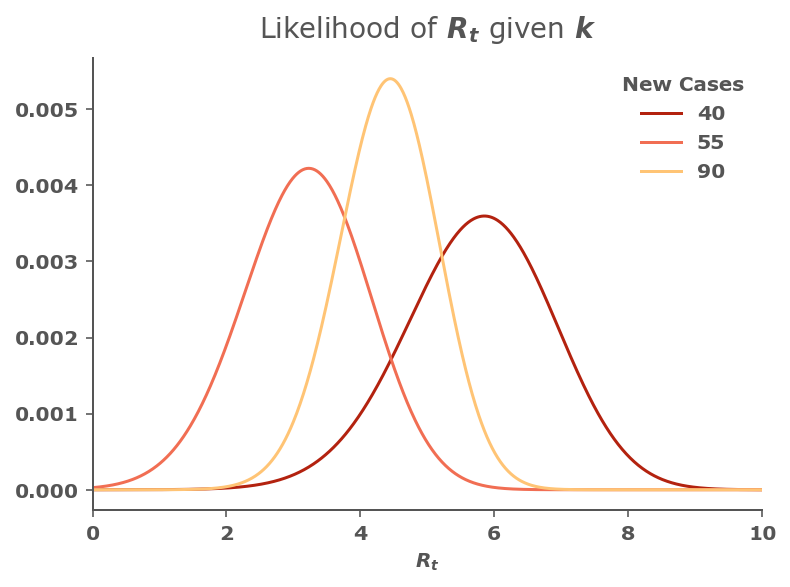

In [42]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood without our Gaussian update) to get the posteriors. Let's do that using the cumulative product of each successive day:

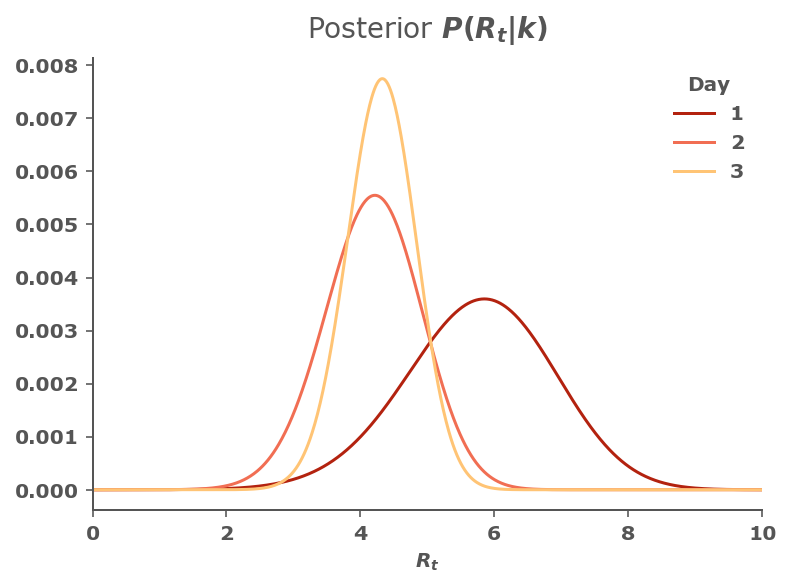

In [43]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [44]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

In [45]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=['Low_{:.0f}'.format(p*100),
                            'High_{:.0f}'.format(p*100)])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

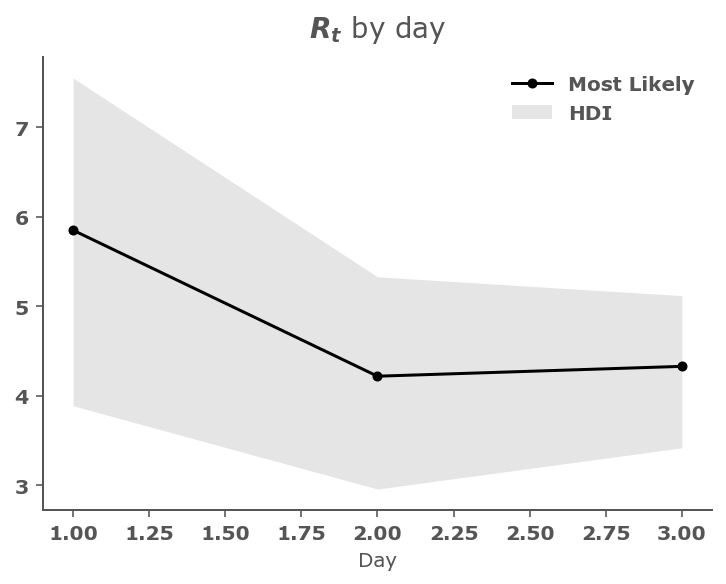

In [46]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title='$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply the process to this sample. Next, however, we'll turn to a real-world application where this process is necessary.

# Real-World Application to Indian Data

### Setup


Loading Indian case data from https://api.covid19india.org/csv/latest/state_wise_daily.csv

In [47]:
url_in= 'https://api.covid19india.org/csv/latest/state_wise_daily.csv'
states_in = pd.read_csv(url_in,
                        parse_dates=['Date'],
                        squeeze=True).sort_index()
states_in.iloc[-1]

Date      2020-05-04 00:00:00
Status               Deceased
TT                        103
AN                          0
AP                          0
AR                          0
AS                          0
BR                          0
CH                          0
CT                          0
DN                          0
DD                          0
DL                          0
GA                          0
GJ                         29
HR                          1
HP                          0
JK                          0
JH                          0
KA                          2
KL                          0
LA                          0
LD                          0
MP                          9
MH                         35
MN                          0
ML                          0
MZ                          0
NL                          0
OR                          0
PY                          0
PB                          2
RJ                          6
SK        

In [48]:
df = states_in[states_in['Status']== 'Confirmed']
df = df.drop('TT', axis = 1)
df = df.drop('Status', axis = 1)
df.tail()

,Date,AN,AP,AR,AS,BR,CH,CT,DN,DD,...,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
141,2020-04-30,0,71,0,5,22,6,2,0,0,...,0,105,144,0,161,22,0,77,2,33
144,2020-05-01,0,60,0,0,41,14,3,0,0,...,0,105,82,0,203,6,0,117,0,37
147,2020-05-02,0,62,0,0,15,6,0,0,0,...,4,187,106,0,231,17,2,159,2,127
150,2020-05-03,0,58,0,0,36,17,0,0,0,...,0,330,114,0,266,21,12,158,1,276
153,2020-05-04,0,67,0,0,11,5,1,0,0,...,0,130,175,0,527,3,13,121,0,61


In [49]:
df1 = df.T
df1 = df1.reset_index(inplace = False)
new_header = df1.iloc[0] 
df1 = df1[1:] 
df1.columns = new_header
df1 = df1.rename(columns = {'Date':'state'})
df1.head()

,state,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,...,2020-04-25 00:00:00,2020-04-26 00:00:00,2020-04-27 00:00:00,2020-04-28 00:00:00,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00,2020-05-03 00:00:00,2020-05-04 00:00:00
1,AN,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
2,AP,1,0,0,0,0,2,0,2,1,...,61,81,80,82,73,71,60,62,58,67
3,AR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AS,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,5,0,0,0,0
5,BR,0,0,0,0,0,0,0,0,2,...,28,26,69,20,37,22,41,15,36,11


In [50]:
new_df = df1.melt(id_vars=["state"], 
        var_name="date", 
        value_name="positive")
state_df = new_df.sort_values(by = ['state','date'])
state_df = state_df.reset_index(drop = True)
state_df.set_index(['state', 'date'], inplace=True)
convert_dict = {'positive': float, 
               } 
state_df = state_df.astype(convert_dict) 
state_df
              

positive
state date                
AN    2020-03-14       0.0
      2020-03-15       0.0
      2020-03-16       0.0
      2020-03-17       0.0
      2020-03-18       0.0
...                    ...
WB    2020-04-30      33.0
      2020-05-01      37.0
      2020-05-02     127.0
      2020-05-03     276.0
      2020-05-04      61.0

[1924 rows x 1 columns]

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

In [51]:
states = state_df.squeeze()
print(type(states))

<class 'pandas.core.series.Series'>


In [52]:
state_names = new_df.state.unique()
print(state_names)

FILTERED_REGION_CODES_NOT_OK = ['AR', 'DD', 'DN', 'LD', 'MN', 'MZ', 'NL', 'SK', 'TR']
FILTERED_REGION_CODES = ['AN', 'AR', 'AS', 'CH', 'CT', 'DD', 'DN',
                         'GA', 'HP', 'JH', 'LA', 'LD', 'ML', 'MN',
                         'MZ', 'NL', 'OR', 'PY', 'SK', 'TR', 'UT']

['AN' 'AP' 'AR' 'AS' 'BR' 'CH' 'CT' 'DN' 'DD' 'DL' 'GA' 'GJ' 'HR' 'HP'
 'JK' 'JH' 'KA' 'KL' 'LA' 'LD' 'MP' 'MH' 'MN' 'ML' 'MZ' 'NL' 'OR' 'PY'
 'PB' 'RJ' 'SK' 'TN' 'TG' 'TR' 'UP' 'UT' 'WB']


7
2.0


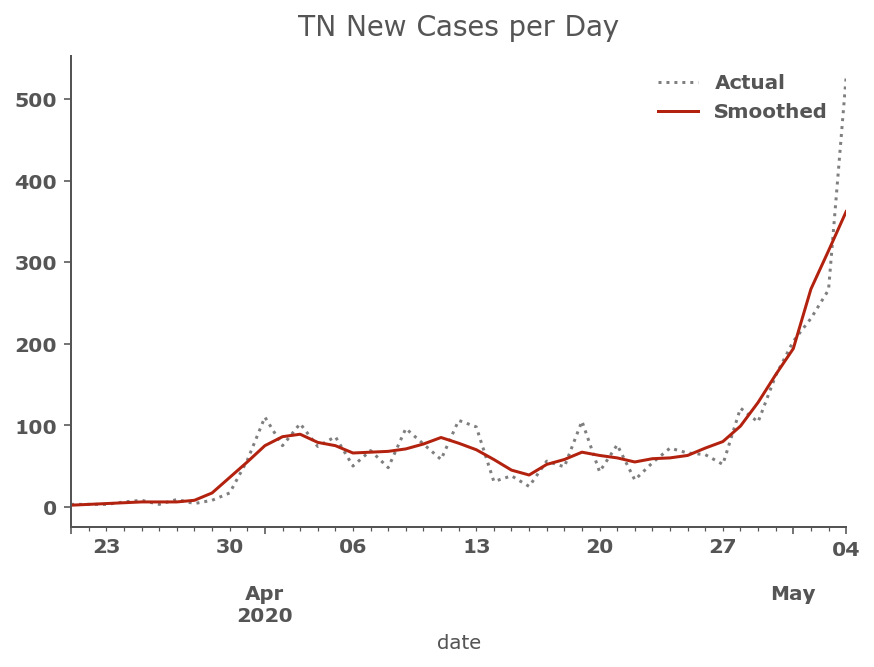

In [53]:
state_name = 'TN'

def prepare_cases(cases, cutoff=2):
    new_cases = cases
#     print(new_cases)
    smoothed = new_cases.rolling(5,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
#     print(smoothed)
    idx_start = np.searchsorted(smoothed, cutoff)
    print(idx_start)
    print(smoothed[idx_start])
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

### Running the Algorithm

#### Choosing the Gaussian $\sigma$ for $P(R_t|R_{t-1})$

> Note: you can safely skip this section if you trust that we chose the right value of $\sigma$ for the process below. Otherwise, read on.

The original approach simply selects yesterday's posterior as today's prior. While intuitive, doing so doesn't allow for our belief that the value of $R_t$ has likely changed from yesterday. To allow for that change, we apply Gaussian noise to the prior distribution with some standard deviation $\sigma$. The higher $\sigma$ the more noise and the more we will expect the value of $R_t$ to drift each day. Interestingly, applying noise on noise iteratively means that there will be a natural decay of distant posteriors. This approach has a similar effect of windowing, but is more robust and doesn't arbitrarily forget posteriors after a certain time like my previous approach. Specifically, windowing computed a fixed $R_t$ at each time $t$ that explained the surrounding $w$ days of cases, while the new approach computes a series of $R_t$ values that explains all the cases, assuming that $R_t$ fluctuates by about $\sigma$ each day.

However, there's still an arbitrary choice: what should $\sigma$ be? Adam Lerer pointed out that we can use the process of maximum likelihood to inform our choice. Here's how it works:

Maximum likelihood says that we'd like to choose a $\sigma$ that maximizes the likelihood of seeing our data $k$: $P(k|\sigma)$. Since $\sigma$ is a fixed value, let's leave it out of the notation, so we're trying to maximize $P(k)$ over all choices of $\sigma$.

Since $P(k)=P(k_0,k_1,\ldots,k_t)=P(k_0)P(k_1)\ldots P(k_t)$ we need to define $P(k_t)$. It turns out this is the denominator of Bayes rule:

$$P(R_t|k_t) = \frac{P(k_t|R_t)P(R_t)}{P(k_t)}$$

To calculate it, we notice that the numerator is actually just the joint distribution of $k$ and $R$:

$$ P(k_t,R_t) =  P(k_t|R_t)P(R_t) $$

We can marginalize the distribution over $R_t$ to get $P(k_t)$:

$$ P(k_t) = \sum_{R_{t}}{P(k_t|R_t)P(R_t)} $$

So, if we sum the distribution of the numerator over all values of $R_t$, we get $P(k_t)$. And since we're calculating that anyway as we're calculating the posterior, we'll just keep track of it separately.

Since we're looking for the value of $\sigma$ that maximizes $P(k)$ overall, we actually want to maximize: 

$$\prod_{t,i}{p(k_{ti})}$$

where $t$ are all times and $i$ is each state.

Since we're multiplying lots of tiny probabilities together, it can be easier (and less error-prone) to take the $\log$ of the values and add them together. Remember that $\log{ab}=\log{a}+\log{b}$. And since logarithms are monotonically increasing, maximizing the sum of the $\log$ of the probabilities is the same as maximizing the product of the non-logarithmic probabilities for any choice of $\sigma$.

### Function for Calculating the Posteriors

To calculate the posteriors we follow these steps:
1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
  - Based on [info from the cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) we will choose a Gamma with mean 7.
5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [54]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        print(posteriors[current_day])
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

0.00     1.085579e-05
0.01     1.164542e-05
0.02     1.248146e-05
0.03     1.336584e-05
0.04     1.430051e-05
             ...     
11.96    8.048507e-07
11.97    7.766424e-07
11.98    7.486999e-07
11.99    7.210541e-07
12.00    6.937353e-07
Name: 2020-03-22 00:00:00, Length: 1201, dtype: float64
0.00     2.372594e-05
0.01     2.496637e-05
0.02     2.625408e-05
0.03     2.759015e-05
0.04     2.897568e-05
             ...     
11.96    5.662042e-09
11.97    5.402668e-09
11.98    5.150623e-09
11.99    4.905914e-09
12.00    4.668541e-09
Name: 2020-03-23 00:00:00, Length: 1201, dtype: float64
0.00     3.598799e-05
0.01     3.765710e-05
0.02     3.937553e-05
0.03     4.114377e-05
0.04     4.296234e-05
             ...     
11.96    5.955309e-12
11.97    5.614770e-12
11.98    5.289794e-12
11.99    4.979845e-12
12.00    4.684409e-12
Name: 2020-03-24 00:00:00, Length: 1201, dtype: float64
0.00     4.831110e-05
0.01     5.043372e-05
0.02     5.261006e-05
0.03     5.484013e-05
0.04     5.712397e

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

date     2020-03-21    2020-03-22    2020-03-23    2020-03-24    2020-03-25  \
0.00   0.000000e+00  1.085579e-05  2.372594e-05  3.598799e-05  4.831110e-05   
0.01   1.653859e-09  1.164542e-05  2.496637e-05  3.765710e-05  5.043372e-05   
0.02   1.309922e-08  1.248146e-05  2.625408e-05  3.937553e-05  5.261006e-05   
0.03   4.376997e-08  1.336584e-05  2.759015e-05  4.114377e-05  5.484013e-05   
0.04   1.027187e-07  1.430051e-05  2.897568e-05  4.296234e-05  5.712397e-05   
...             ...           ...           ...           ...           ...   
11.96  1.827565e-05  8.048507e-07  5.662042e-09  5.955309e-12  1.045520e-15   
11.97  1.813923e-05  7.766424e-07  5.402668e-09  5.614770e-12  9.704776e-16   
11.98  1.800379e-05  7.486999e-07  5.150623e-09  5.289794e-12  9.003521e-16   
11.99  1.786932e-05  7.210541e-07  4.905914e-09  4.979845e-12  8.348414e-16   
12.00  1.773582e-05  6.937353e-07  4.668541e-09  4.684409e-12  7.736615e-16   

date     2020-03-26    2020-03-27    2020-03-28    

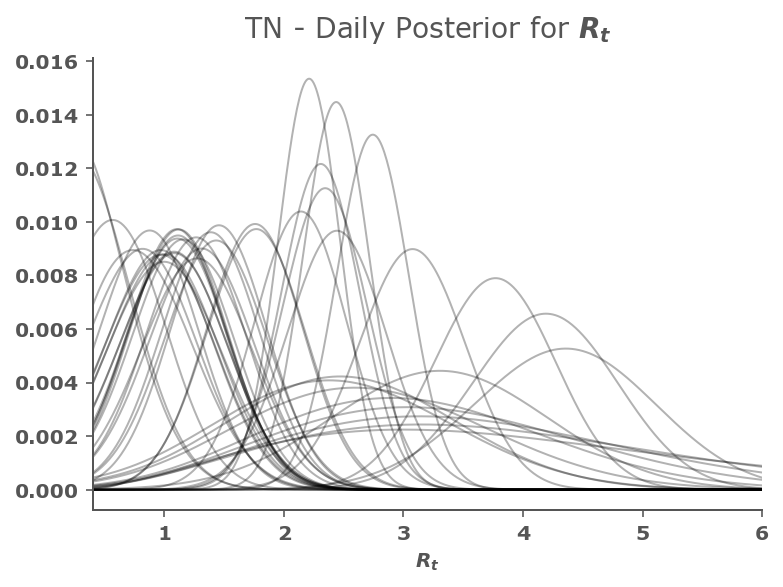

In [55]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');
print(posteriors)

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [56]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-30,2.35,1.73,2.90
2020-05-01,2.31,1.75,2.83
2020-05-02,2.74,2.24,3.23
2020-05-03,2.44,1.96,2.87
2020-05-04,2.21,1.75,2.61


In [57]:
from datetime import date
print(date.today())

2020-05-05


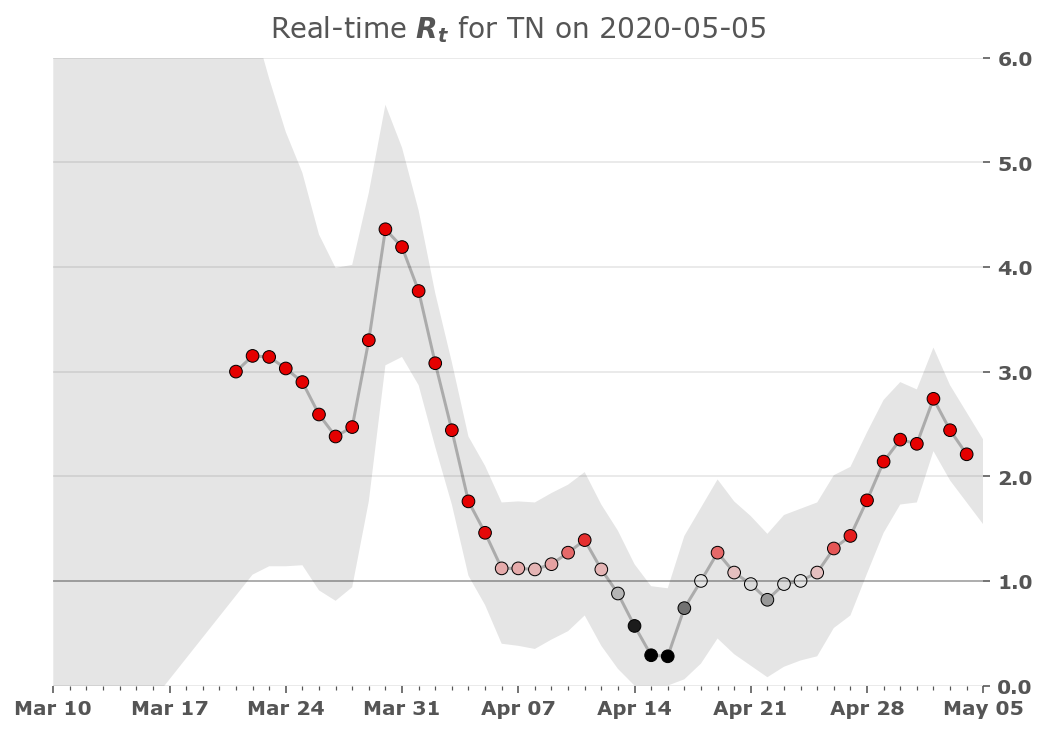

In [58]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')

    extended = pd.date_range(start=pd.Timestamp('2020-03-10'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 6.0)
    ax.set_xlim(pd.Timestamp('2020-03-10'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
#     if :
#         fig.set_facecolor('w')
#     else :
#         fig.set_facecolor('')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name} on {date.today()}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Choosing the optimal $\sigma$

In the previous section we described choosing an optimal $\sigma$, but we just assumed a value. But now that we can evaluate each state with any sigma, we have the tools for choosing the optimal $\sigma$.

Above we said we'd choose the value of $\sigma$ that maximizes the likelihood of the data $P(k)$. Since we don't want to overfit on any one state, we choose the sigma that maximizes $P(k)$ over every state. To do this, we add up all the log likelihoods per state for each value of sigma then choose the maximum.

> Note: this takes a while!

In [59]:
sigmas = np.linspace(1/20, 1, 20)
FILTERED_REGION_CODES = ['AN', 'AR', 'AS', 'CH', 'CT', 'DD', 'DN',
                         'GA', 'HP', 'JH','OR', 'LA', 'LD', 'ML', 'MN',
                         'MZ', 'NL', 'PY', 'SK', 'TR', 'UT']
targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]
#states_to_process = states

results = {}

for state_name, cases in states_to_process.groupby(level='state'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=5)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=3)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


In [60]:
print(state_name)
new, smoothed = prepare_cases(cases, cutoff=25)

if len(smoothed) == 0:
    new, smoothed = prepare_cases(cases, cutoff=10)

result = {}

# Holds all posteriors with every given value of sigma
result['posteriors'] = []

# Holds the log likelihood across all k for each value of sigma
result['log_likelihoods'] = []

for sigma in sigmas:
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
    result['posteriors'].append(posteriors)
    result['log_likelihoods'].append(log_likelihood)

# Store all results keyed off of state name
results[state_name] = result
clear_output(wait=True)

WB
32
25.0
0.00     3.209266e-07
0.01     4.597556e-07
0.02     6.455309e-07
0.03     8.893005e-07
0.04     1.203351e-06
             ...     
11.96    2.051229e-28
11.97    1.703467e-28
11.98    1.388261e-28
11.99    1.107372e-28
12.00    8.625245e-29
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     2.021598e-06
0.01     2.603708e-06
0.02     3.310117e-06
0.03     4.160431e-06
0.04     5.176954e-06
             ...     
11.96    2.078494e-54
11.97    1.546586e-54
11.98    1.138259e-54
11.99    8.265216e-55
12.00    5.906245e-55
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     2.330445e-06
0.01     2.906329e-06
0.02     3.575173e-06
0.03     4.347704e-06
0.04     5.237402e-06
             ...     
11.96    9.492022e-76
11.97    6.397986e-76
11.98    4.301999e-76
11.99    2.880332e-76
12.00    1.916006e-76
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     1.072082e-06
0.01     1.322464e-06
0.02     1.607765e-06
0.03     1.

0.00     7.300794e-06
0.01     8.254640e-06
0.02     9.310642e-06
0.03     1.047688e-05
0.04     1.176176e-05
             ...     
11.96    1.763490e-28
11.97    1.485532e-28
11.98    1.247828e-28
11.99    1.045095e-28
12.00    8.726717e-29
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     4.536614e-05
0.01     4.949701e-05
0.02     5.391022e-05
0.03     5.861882e-05
0.04     6.363634e-05
             ...     
11.96    1.322802e-53
11.97    1.005238e-53
11.98    7.634391e-54
11.99    5.794165e-54
12.00    4.394367e-54
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     5.199638e-05
0.01     5.636153e-05
0.02     6.097814e-05
0.03     6.585424e-05
0.04     7.099828e-05
             ...     
11.96    5.089750e-72
11.97    3.486196e-72
11.98    2.386442e-72
11.99    1.632659e-72
12.00    1.116317e-72
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     2.533274e-05
0.01     2.750717e-05
0.02     2.981045e-05
0.03     3.224697e-05


0.00     2.843731e-05
0.01     3.063887e-05
0.02     3.298041e-05
0.03     3.546846e-05
0.04     3.810967e-05
             ...     
11.96    1.747152e-28
11.97    1.488543e-28
11.98    1.266704e-28
11.99    1.076625e-28
12.00    9.139489e-29
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     1.725392e-04
0.01     1.818738e-04
0.02     1.915800e-04
0.03     2.016666e-04
0.04     2.121425e-04
             ...     
11.96    3.295256e-52
11.97    2.526090e-52
11.98    1.935681e-52
11.99    1.482668e-52
12.00    1.135217e-52
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     1.942813e-04
0.01     2.043697e-04
0.02     2.148179e-04
0.03     2.256319e-04
0.04     2.368178e-04
             ...     
11.96    2.166475e-66
11.97    1.542846e-66
11.98    1.098137e-66
11.99    7.811872e-67
12.00    5.554162e-67
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     9.816766e-05
0.01     1.036429e-04
0.02     1.093387e-04
0.03     1.152602e-04


0.00      8.259470e-10
0.01      9.558790e-10
0.02      1.105587e-09
0.03      1.277973e-09
0.04      1.476349e-09
             ...      
11.96    7.839437e-214
11.97    2.415357e-214
11.98    7.427708e-215
11.99    2.279839e-215
12.00    6.984395e-216
Name: (WB, 2020-05-04 00:00:00), Length: 1201, dtype: float64
0.00     6.587270e-05
0.01     6.951659e-05
0.02     7.332502e-05
0.03     7.730331e-05
0.04     8.145681e-05
             ...     
11.96    1.794041e-28
11.97    1.537492e-28
11.98    1.316683e-28
11.99    1.126766e-28
12.00    9.635368e-29
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     3.860127e-04
0.01     4.008124e-04
0.02     4.160139e-04
0.03     4.316224e-04
0.04     4.476428e-04
             ...     
11.96    1.853195e-50
11.97    1.437029e-50
11.98    1.113865e-50
11.99    8.630238e-51
12.00    6.683985e-51
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     4.207892e-04
0.01     4.367677e-04
0.02     4.531533e-04
0.03     4.

0.00     1.186266e-04
0.01     1.237559e-04
0.02     1.290645e-04
0.03     1.345567e-04
0.04     1.402366e-04
             ...     
11.96    1.868811e-28
11.97    1.607215e-28
11.98    1.381511e-28
11.99    1.186876e-28
12.00    1.019121e-28
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     6.653190e-04
0.01     6.849630e-04
0.02     7.049953e-04
0.03     7.254176e-04
0.04     7.462318e-04
             ...     
11.96    1.372335e-48
11.97    1.077209e-48
11.98    8.452239e-49
11.99    6.629406e-49
12.00    5.197669e-49
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     6.927737e-04
0.01     7.136055e-04
0.02     7.348407e-04
0.03     7.564800e-04
0.04     7.785240e-04
             ...     
11.96    2.443090e-55
11.97    1.860324e-55
11.98    1.415986e-55
11.99    1.077334e-55
12.00    8.193366e-56
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     3.533780e-04
0.01     3.656597e-04
0.02     3.782515e-04
0.03     3.911571e-04


0.00     1.841947e-04
0.01     1.907596e-04
0.02     1.975111e-04
0.03     2.044526e-04
0.04     2.115877e-04
             ...     
11.96    1.961714e-28
11.97    1.691039e-28
11.98    1.457090e-28
11.99    1.254968e-28
12.00    1.080419e-28
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     9.823080e-04
0.01     1.005745e-03
0.02     1.029528e-03
0.03     1.053656e-03
0.04     1.078130e-03
             ...     
11.96    9.414206e-47
11.97    7.474297e-47
11.98    5.931954e-47
11.99    4.706149e-47
12.00    3.732277e-47
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     9.669040e-04
0.01     9.910541e-04
0.02     1.015573e-03
0.03     1.040459e-03
0.04     1.065712e-03
             ...     
11.96    6.939425e-51
11.97    5.413235e-51
11.98    4.221122e-51
11.99    3.290305e-51
12.00    2.563786e-51
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     4.838991e-04
0.01     4.983327e-04
0.02     5.130763e-04
0.03     5.281326e-04


0.00     2.595177e-04
0.01     2.674145e-04
0.02     2.755000e-04
0.03     2.837769e-04
0.04     2.922478e-04
             ...     
11.96    2.069644e-28
11.97    1.787007e-28
11.98    1.542395e-28
11.99    1.330772e-28
12.00    1.147755e-28
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     1.310967e-03
0.01     1.337048e-03
0.02     1.363419e-03
0.03     1.390076e-03
0.04     1.417018e-03
             ...     
11.96    4.959260e-45
11.97    3.977455e-45
11.98    3.188909e-45
11.99    2.555802e-45
12.00    2.047672e-45
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     1.211924e-03
0.01     1.237911e-03
0.02     1.264218e-03
0.03     1.290845e-03
0.04     1.317786e-03
             ...     
11.96    3.468781e-47
11.97    2.758158e-47
11.98    2.192353e-47
11.99    1.742012e-47
12.00    1.383696e-47
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     5.897857e-04
0.01     6.053757e-04
0.02     6.212597e-04
0.03     6.374397e-04


0.00     3.415532e-04
0.01     3.506516e-04
0.02     3.599368e-04
0.03     3.694111e-04
0.04     3.790766e-04
             ...     
11.96    2.192008e-28
11.97    1.894960e-28
11.98    1.637615e-28
11.99    1.414743e-28
12.00    1.221789e-28
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     1.631860e-03
0.01     1.659541e-03
0.02     1.687450e-03
0.03     1.715583e-03
0.04     1.743936e-03
             ...     
11.96    1.847753e-43
11.97    1.495102e-43
11.98    1.209351e-43
11.99    9.778869e-44
12.00    7.904585e-44
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     1.413111e-03
0.01     1.439782e-03
0.02     1.466724e-03
0.03     1.493935e-03
0.04     1.521412e-03
             ...     
11.96    3.844370e-44
11.97    3.103776e-44
11.98    2.505032e-44
11.99    2.021129e-44
12.00    1.630168e-44
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     6.661972e-04
0.01     6.821775e-04
0.02     6.984294e-04
0.03     7.149542e-04


0.00      1.259031e-07
0.01      1.372206e-07
0.02      1.495095e-07
0.03      1.628486e-07
0.04      1.773230e-07
             ...      
11.96    2.912001e-119
11.97    1.452089e-119
11.98    7.231886e-120
11.99    3.597211e-120
12.00    1.787045e-120
Name: (WB, 2020-05-03 00:00:00), Length: 1201, dtype: float64
0.00      5.212837e-06
0.01      5.615706e-06
0.02      6.047576e-06
0.03      6.510361e-06
0.04      7.006083e-06
             ...      
11.96    1.565195e-148
11.97    6.781416e-149
11.98    2.933822e-149
11.99    1.267383e-149
12.00    5.466911e-150
Name: (WB, 2020-05-04 00:00:00), Length: 1201, dtype: float64
0.00     4.275853e-04
0.01     4.377457e-04
0.02     4.480887e-04
0.03     4.586158e-04
0.04     4.693286e-04
             ...     
11.96    2.329444e-28
11.97    2.015646e-28
11.98    1.743574e-28
11.99    1.507753e-28
12.00    1.303417e-28
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     1.932734e-03
0.01     1.961164e-03
0.02     1.989762e-03


0.00     5.153579e-04
0.01     5.264432e-04
0.02     5.377049e-04
0.03     5.491442e-04
0.04     5.607622e-04
             ...     
11.96    2.483304e-28
11.97    2.150356e-28
11.98    1.861496e-28
11.99    1.610958e-28
12.00    1.393724e-28
Name: (WB, 2020-04-16 00:00:00), Length: 1201, dtype: float64
0.00     2.207238e-03
0.01     2.235778e-03
0.02     2.264429e-03
0.03     2.293188e-03
0.04     2.322049e-03
             ...     
11.96    8.577411e-41
11.97    7.040019e-41
11.98    5.776371e-41
11.99    4.738052e-41
12.00    3.885151e-41
Name: (WB, 2020-04-17 00:00:00), Length: 1201, dtype: float64
0.00     1.683780e-03
0.01     1.709813e-03
0.02     1.736037e-03
0.03     1.762449e-03
0.04     1.789046e-03
             ...     
11.96    1.399365e-39
11.97    1.155172e-39
11.98    9.533056e-40
11.99    7.864782e-40
12.00    6.486499e-40
Name: (WB, 2020-04-18 00:00:00), Length: 1201, dtype: float64
0.00     7.474338e-04
0.01     7.629527e-04
0.02     7.786980e-04
0.03     7.946703e-04


Now that we have all the log likelihoods, we can sum for each value of sigma across states, graph it, then choose the maximum.

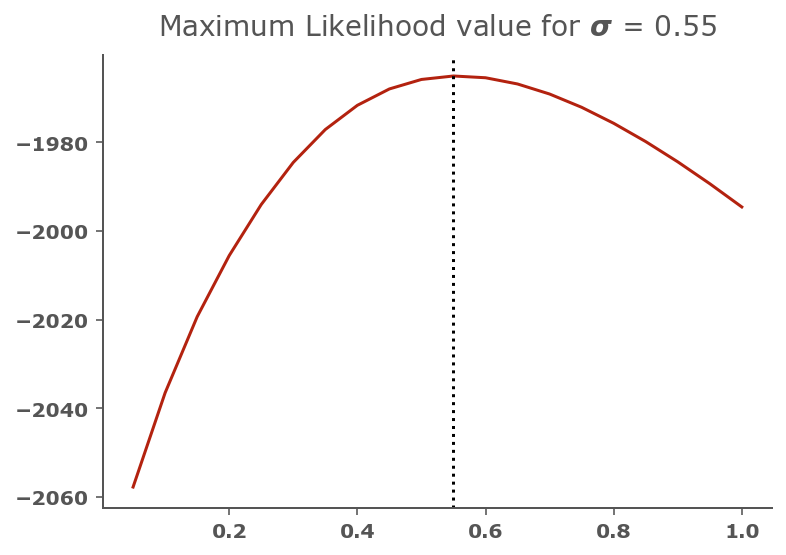

In [61]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

### Compile Final Results

Given that we've selected the optimal $\sigma$, let's grab the precalculated posterior corresponding to that value of $\sigma$ for each state. Let's also calculate the 90% and 50% highest density intervals (this takes a little while) and also the most likely value.

In [62]:
# result.loc['WB'].loc['2020-04-25']['ML']

In [63]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Done.


In [64]:
final_results

ML  Low_90  High_90  Low_50  High_50
state date                                              
AP    2020-03-29  3.00    0.86     6.84    1.86     4.27
      2020-03-30  6.57    3.76     9.19    5.32     7.58
      2020-03-31  5.04    3.28     6.67    4.24     5.64
      2020-04-01  3.69    2.25     4.94    3.02     4.13
      2020-04-02  2.69    1.43     3.85    2.09     3.09
...                ...     ...      ...     ...      ...
WB    2020-04-30  1.59    0.45     2.64    1.05     1.97
      2020-05-01  3.68    2.64     4.61    3.21     4.02
      2020-05-02  3.07    2.21     3.86    2.67     3.35
      2020-05-03  2.54    1.72     3.24    2.22     2.84
      2020-05-04  2.03    1.26     2.71    1.66     2.26

[629 rows x 5 columns]

### Plot All States

In [65]:
# for i, (state_name, result) in enumerate(final_results.groupby('state')):
#     print(result[state_name])

In [66]:
results_date = final_results.sort_values(by=['date'])
results_date

ML  Low_90  High_90  Low_50  High_50
state date                                              
MH    2020-03-14  3.00    0.86     6.84    1.86     4.27
      2020-03-15  1.90    0.41     3.66    1.20     2.56
      2020-03-16  1.41    0.03     2.81    0.68     1.92
      2020-03-17  0.83    0.00     2.32    0.26     1.32
      2020-03-18  0.62    0.00     2.13    0.08     1.03
...                ...     ...      ...     ...      ...
UP    2020-05-04  1.30    0.51     1.99    0.94     1.55
GJ    2020-05-04  1.21    0.64     1.69    0.96     1.39
KL    2020-05-04  0.60    0.00     2.19    0.07     1.02
PB    2020-05-04  1.74    1.04     2.32    1.40     1.93
WB    2020-05-04  2.03    1.26     2.71    1.66     2.26

[629 rows x 5 columns]

In [67]:
import datetime

Text(0.5, 1.03, 'Rt for India as on 2020-05-04')

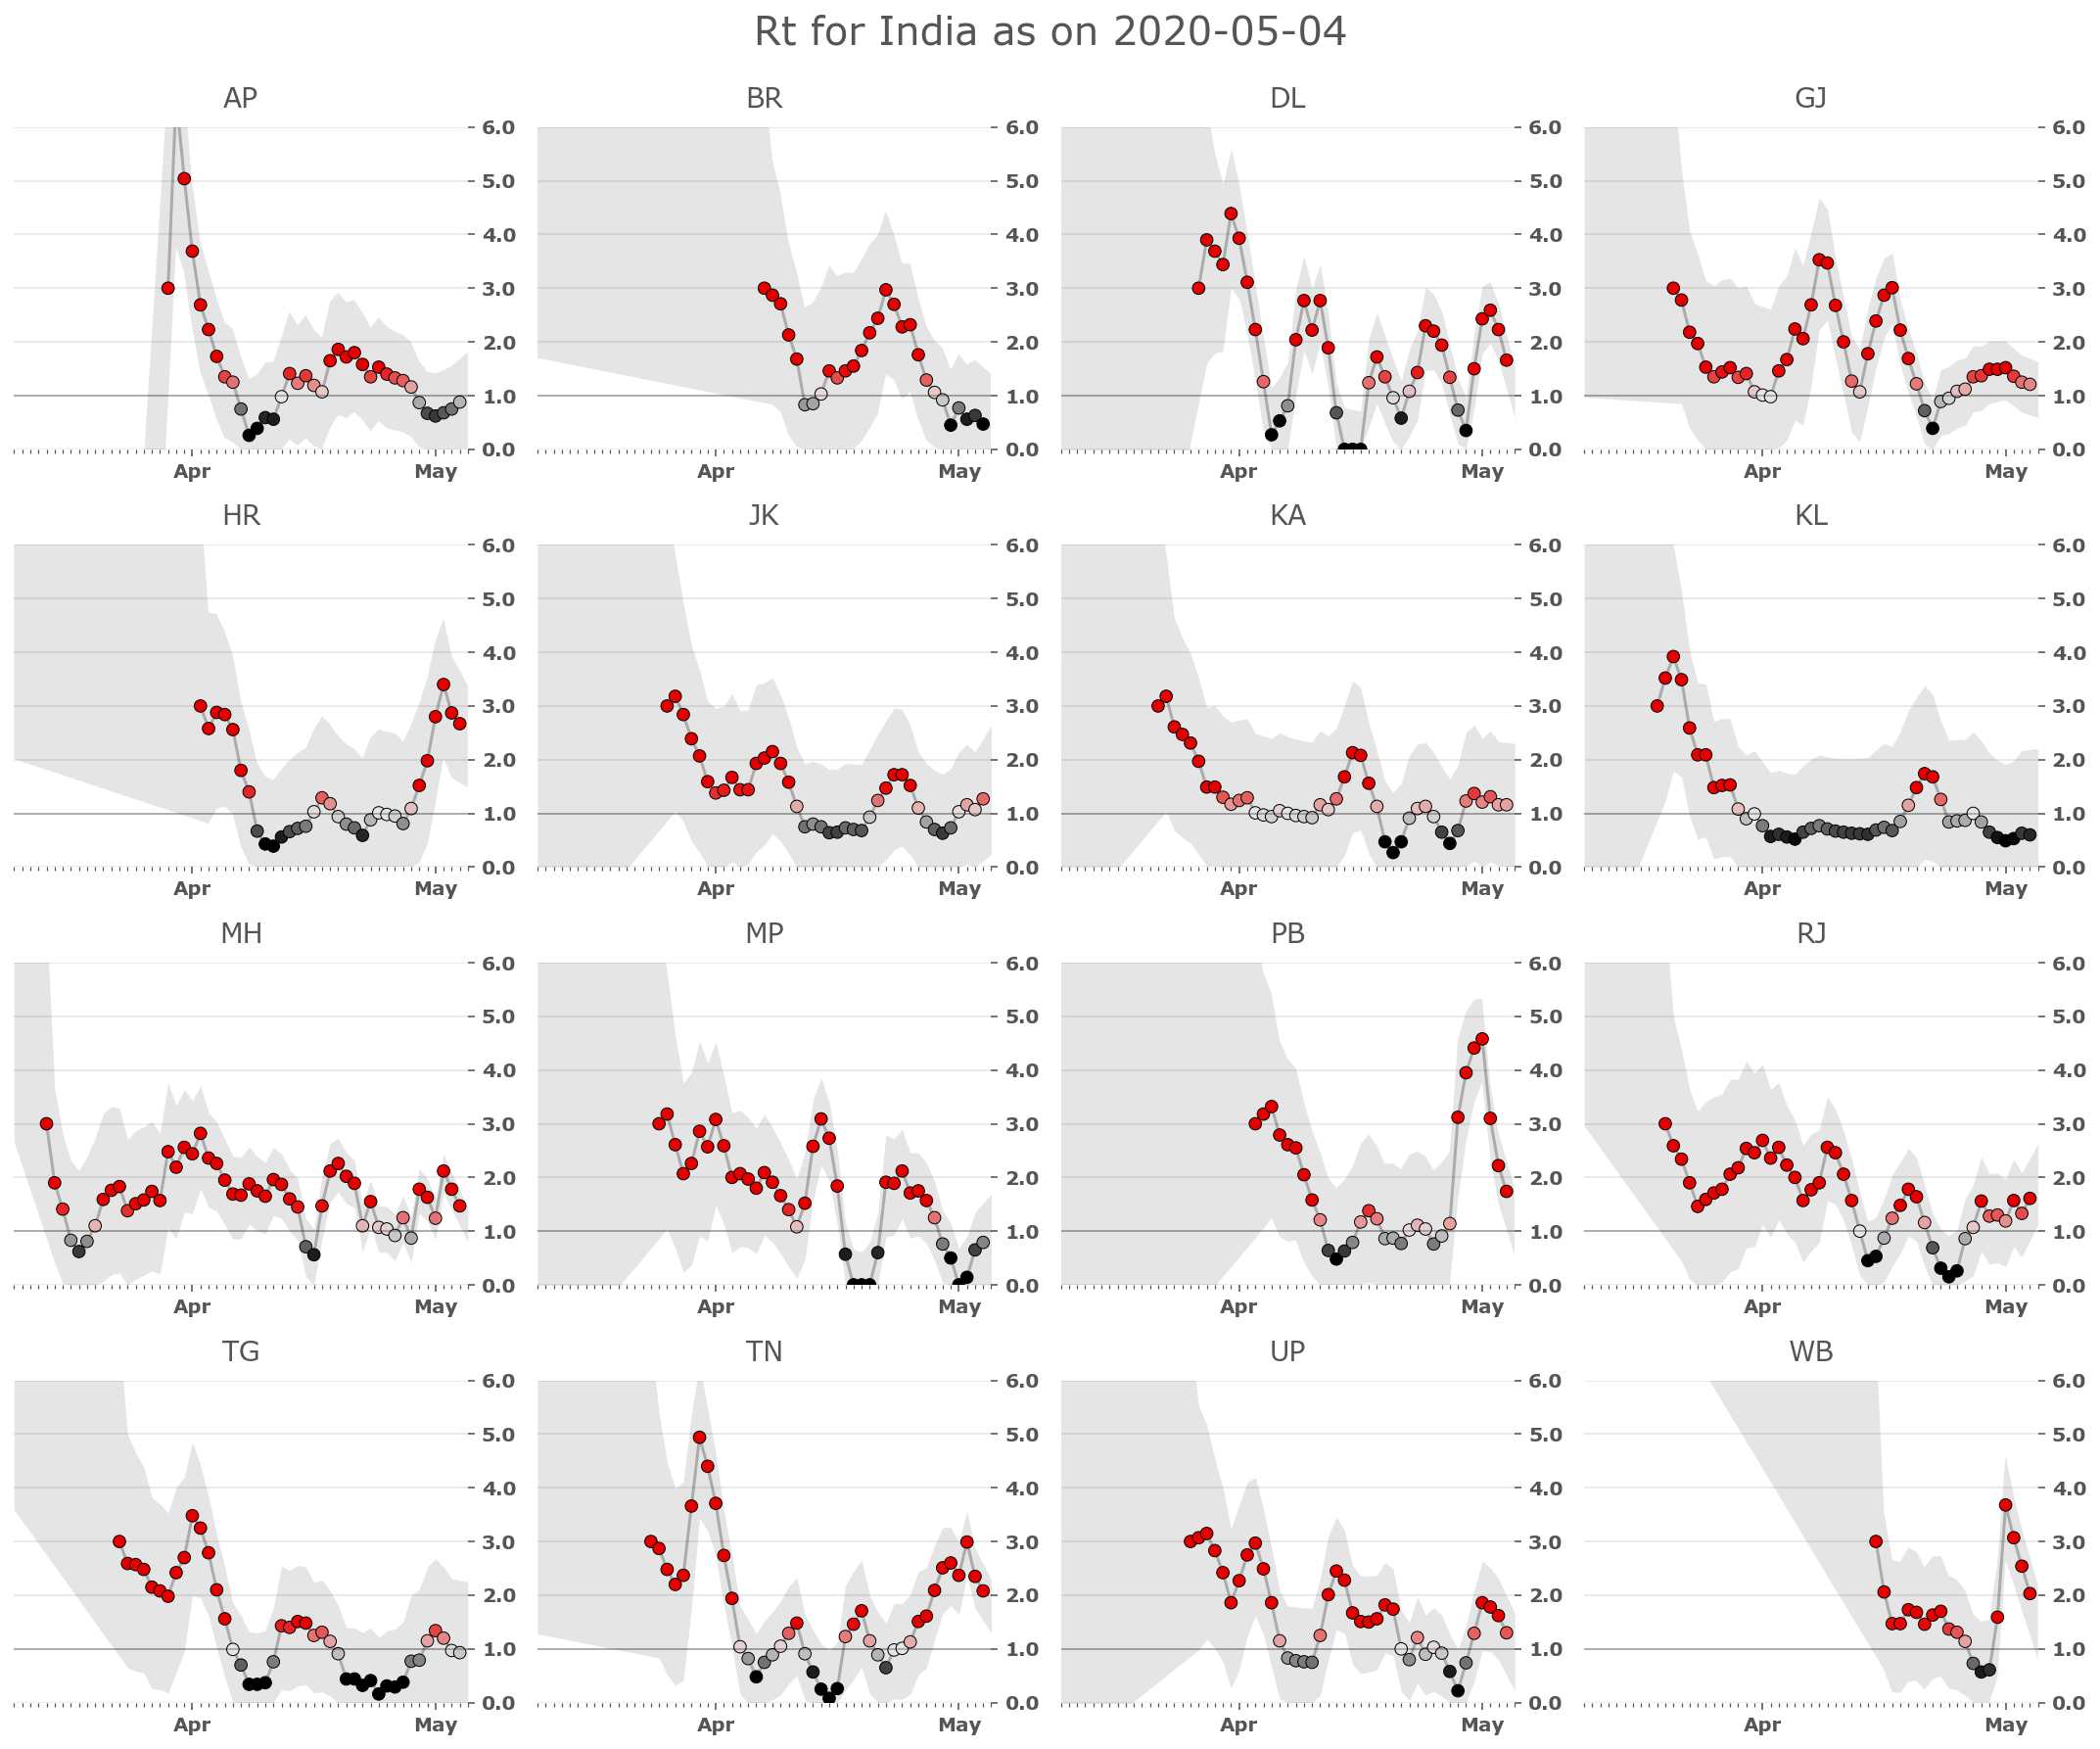

In [68]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
#     print (result)
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
# fig.set_facecolor('w')
fig.suptitle(f'Rt for India as on {date.today() - datetime.timedelta(days=1)}', fontsize=20, x = 0.5, y = 1.03)


In [69]:
date.today()

datetime.date(2020, 5, 5)

In [70]:
fig.savefig(f'Rt for {date.today() - datetime.timedelta(days=1)}.jpg',bbox_inches='tight')

### Export Data to CSV

In [71]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv('data/rt_old.csv')
results_date.to_csv('data/rt_datewise.csv')

### Standings

In [72]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [73]:
final_results.loc['2020-03-20']

KeyError: '2020-03-20'

In [ ]:
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
#         if state_name in no_lockdown:
#             bar.set_color(NONE_COLOR)
#         if state_name in partial_lockdown:
            bar.set_color(FULL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

In [ ]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

In [ ]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

In [ ]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()